# DFM-Python 완전 가이드: 동적 요인 모델 사용법과 결과 해석

이 노트북은 `dfm-python` v0.3.0 패키지를 사용하여 동적 요인 모델(Dynamic Factor Model, DFM)을 구축하고 결과를 해석하는 방법을 단계별로 설명합니다.

## 목차

1. [패키지 소개 및 설치](#1-패키지-소개-및-설치)
2. [데이터 준비](#2-데이터-준비)
3. [모델 설정 및 학습](#3-모델-설정-및-학습)
4. [모델 품질 평가](#4-모델-품질-평가)
5. [예측 및 시각화](#5-예측-및-시각화)
6. [Nowcasting 및 News Decomposition](#6-nowcasting-및-news-decomposition)
7. [Backtesting](#7-backtesting)

**Note**: 이 튜토리얼은 빠른 실행을 위해 minimal setting을 사용합니다 (max_iter=10, T=100).
- `max_iter=1`은 너무 작아서 모델이 제대로 학습되지 않습니다 (Q 행렬이 초기값 그대로, 요인 설명력이 음수).
- `max_iter=10`으로 설정하여 의미 있는 결과를 얻을 수 있습니다.
- 실제 사용 시에는 더 큰 값으로 설정하는 것을 권장합니다 (max_iter=50~5000).


## 1. 패키지 소개 및 설치

### 동적 요인 모델(Dynamic Factor Model)이란?

동적 요인 모델은 여러 시계열 데이터에서 공통 요인(common factors)을 추출하는 통계 모델입니다.

**핵심 아이디어:**
- 여러 시계열(예: GDP, 소비, 투자, 고용 등)은 소수의 공통 요인에 의해 설명됨
- 각 시계열은 공통 요인과 고유한 특이 성분(idiosyncratic component)의 합으로 표현됨
- 요인은 시간에 따라 동적으로 진화함 (AR 과정)

**주요 용도:**
- **Nowcasting**: 공식 발표 전 현재 시점의 경제 지표 추정
- **Forecasting**: 미래 값 예측
- **News Decomposition**: 새로운 데이터 발표가 예측에 미치는 영향 분석
- **Backtesting**: Pseudo real-time 환경에서 모델 성능 평가
- **Missing Data 처리**: 결측치가 많은 데이터에서도 작동
- **Mixed Frequency**: 월별, 분기별 데이터를 동시에 모델링

**v0.3.0 주요 개선사항:**
- ✅ 완전한 Nowcasting API (`NowcastResult`, `NewsDecompResult` dataclass)
- ✅ Backtesting 기능 (`backtest()` 메서드, `BacktestResult` dataclass)
- ✅ 향상된 반환 타입 (structured results)
- ✅ 시각화 기능 (`BacktestResult.plot()`)


In [1]:
# 패키지 설치 (이미 설치되어 있다면 생략 가능)
# !pip install dfm-python

# 필요한 라이브러리 임포트
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from typing import Optional, cast

# Hydra를 사용한 config 로드를 위해 import
try:
    import hydra
    from hydra import initialize, compose
    from omegaconf import DictConfig
    HYDRA_AVAILABLE = True
except ImportError:
    HYDRA_AVAILABLE = False
    print("⚠️ Hydra가 설치되지 않았습니다. pip install hydra-core로 설치하세요.")

# dfm-python 패키지 임포트
import dfm_python as dfm
from dfm_python.config import DFMConfig, SeriesConfig, BlockConfig, Params

print(f"dfm-python 버전: {dfm.__version__}")
if HYDRA_AVAILABLE:
    print("✅ Hydra 사용 가능")
print("✅ 패키지 임포트 완료!")


dfm-python 버전: 0.3.0
✅ Hydra 사용 가능
✅ 패키지 임포트 완료!


## 2. 데이터 준비

### 2.1 예제 데이터 생성

실제 사용 시에는 CSV 파일이나 데이터베이스에서 데이터를 로드합니다. 여기서는 예제 데이터를 생성합니다.


## 3. 모델 설정

### 3.1 Hydra를 사용한 Config 로드

Hydra를 사용하여 config 파일에서 모델 설정을 자동으로 불러옵니다.
- `config/default.yaml`: 메인 설정 (estimation parameters)
- `config/series/default.yaml`: 시리즈 정의
- `config/blocks/default.yaml`: 블록 구조 정의

이렇게 하면 수동으로 SeriesConfig와 BlockConfig를 만들 필요가 없습니다!


In [2]:
# Hydra를 사용하여 config 로드
# config/default.yaml에서 자동으로 series와 blocks를 불러옵니다

if not HYDRA_AVAILABLE:
    raise ImportError("Hydra가 필요합니다. pip install hydra-core로 설치하세요.")

# Hydra 초기화 및 config 로드
with initialize(config_path="config", version_base="1.3"):
    cfg = compose(config_name="default")

# DFM config 로드
dfm.load_config(hydra=cfg)
config_optional = dfm.get_config()

if config_optional is None:
    raise ValueError("Configuration not loaded")

config: DFMConfig = cast(DFMConfig, config_optional)

print("✅ Config 로드 완료 (Hydra 사용)")
print(f"\nConfig 구조:")
print(f"  - Series 수: {len(config.series)}")
print(f"  - 블록 수: {len(config.block_names)}")
print(f"  - 블록 이름: {', '.join(config.block_names)}")
print(f"  - Clock: {config.clock}")
print(f"  - max_iter: {config.max_iter}, threshold: {config.threshold}")

# 블록별 요인 수 출력 (config 파일에서 자동으로 가져옴)
print(f"\n블록별 요인 수 (config/blocks/default.yaml에서 로드됨):")
total_factors = 0
for block_name in config.block_names:
    block_config = config.blocks[block_name]
    total_factors += block_config.factors
    print(f"  - {block_name}: {block_config.factors}개 요인")

print(f"\n총 요인 수: {total_factors}개 (모든 블록의 요인 합계)")

# 시리즈 수 확인 (synthetic data 생성에 사용)
N = len(config.series)
print(f"\n총 시리즈 수: {N}개 (config/series/default.yaml에서 로드됨)")


✅ Config 로드 완료 (Hydra 사용)

Config 구조:
  - Series 수: 84
  - 블록 수: 6
  - 블록 이름: Block_Global, Block-Export, Block-Labor, Block-Nominal, Block_Consumption, Block_Investment
  - Clock: m
  - max_iter: 5000, threshold: 1e-05

블록별 요인 수 (config/blocks/default.yaml에서 로드됨):
  - Block_Global: 3개 요인
  - Block-Export: 1개 요인
  - Block-Labor: 1개 요인
  - Block-Nominal: 1개 요인
  - Block_Consumption: 1개 요인
  - Block_Investment: 1개 요인

총 요인 수: 8개 (모든 블록의 요인 합계)

총 시리즈 수: 84개 (config/series/default.yaml에서 로드됨)


### 3.2 Config 구조 확인

Hydra로 로드한 config의 구조를 확인합니다. 
블록 DFM 구조에서 각 블록은 자체 요인을 가지며, 시리즈는 여러 블록에 속할 수 있습니다.


In [3]:
# Config에서 블록 구조 확인
# 이미 Hydra로 로드했으므로 config 객체에서 바로 확인 가능

print("블록 DFM 구조 확인:")
print(f"총 블록 수: {len(config.blocks)}")
print(f"총 요인 수: {sum(block.factors for block in config.blocks.values())}개")  # pyright: ignore[reportOptionalMemberAccess]

# 블록별 상세 정보
print(f"\n블록별 상세 정보:")
for block_name, block_config in config.blocks.items():
    print(f"\n  {block_name}:")
    print(f"    - 요인 수: {block_config.factors}")
    print(f"    - AR 차수: {block_config.ar_lag}")
    print(f"    - Clock: {block_config.clock}")
    if block_config.notes:
        print(f"    - 설명: {block_config.notes}")

# 시리즈별 블록 소속 확인 (처음 5개만)
print(f"\n시리즈별 블록 소속 (처음 5개):")
for i, series in enumerate(config.series[:5]):
    print(f"  {series.series_id}: {series.blocks}")


블록 DFM 구조 확인:
총 블록 수: 6
총 요인 수: 8개

블록별 상세 정보:

  Block-Export:
    - 요인 수: 1
    - AR 차수: 1
    - Clock: m

  Block-Labor:
    - 요인 수: 1
    - AR 차수: 1
    - Clock: m

  Block-Nominal:
    - 요인 수: 1
    - AR 차수: 1
    - Clock: m

  Block_Consumption:
    - 요인 수: 1
    - AR 차수: 1
    - Clock: m

  Block_Global:
    - 요인 수: 3
    - AR 차수: 1
    - Clock: m

  Block_Investment:
    - 요인 수: 1
    - AR 차수: 1
    - Clock: m

시리즈별 블록 소속 (처음 5개):
  KOGDP...D: [1, 0, 0, 0, 1, 0]
  KOCNPER.D: [1, 0, 0, 1, 1, 0]
  KOCNGOV.D: [1, 0, 0, 0, 1, 0]
  KOGFCF..D: [1, 0, 0, 0, 1, 1]
  KOEXNGS.D: [1, 0, 0, 0, 1, 0]


### 3.3 Config 설정 확인

Hydra로 로드한 config에는 모든 모델 설정이 포함되어 있습니다.
추가 설정이 필요하면 config 파일을 수정하거나 Hydra override를 사용할 수 있습니다.


In [4]:
# Config 설정 확인
# 이미 Hydra로 로드했으므로 추가 설정 불필요

print("✅ 모델 설정 완료 (Hydra로 자동 로드됨)")
print(f"\n주요 설정:")
print(f"  - Series 수: {len(config.series)}")
print(f"  - 블록 수: {len(config.blocks)}")
print(f"  - 특이 성분 활성화: {config.augment_idio}")
print(f"  - 특이 성분 저주파 처리: {config.augment_idio_slow}")
print(f"  - 최대 반복 횟수: {config.max_iter}")
print(f"  - 수렴 기준: {config.threshold}")
print(f"  - Clock: {config.clock}")

print(f"\n💡 Tip: Config 수정이 필요하면:")
print(f"  - config/default.yaml 수정")
print(f"  - 또는 Hydra override 사용: compose(config_name='default', overrides=['max_iter=100'])")


✅ 모델 설정 완료 (Hydra로 자동 로드됨)

주요 설정:
  - Series 수: 84
  - 블록 수: 6
  - 특이 성분 활성화: True
  - 특이 성분 저주파 처리: True
  - 최대 반복 횟수: 5000
  - 수렴 기준: 1e-05
  - Clock: m

💡 Tip: Config 수정이 필요하면:
  - config/default.yaml 수정
  - 또는 Hydra override 사용: compose(config_name='default', overrides=['max_iter=100'])


## 4. 모델 학습

### 4.1 모델 객체 생성 및 학습

DFM 모델을 생성하고 데이터로 학습시킵니다.

**학습 파라미터:**
- `max_iter`: 최대 EM 알고리즘 반복 횟수
- `threshold`: 수렴 기준 (로그 우도 변화량)


In [5]:
# 시드 설정 (재현성을 위해)
np.random.seed(42)

# Config 구조를 기반으로 synthetic data 생성
# Config에서 시리즈 수와 요인 수 가져오기
N = len(config.series)  # Config에서 시리즈 수 가져오기
# Config의 블록 구조에서 요인 수 계산
num_factors = sum(
    config.blocks[block_name].factors 
    for block_name in config.block_names
)
if num_factors == 0:
    num_factors = 3  # Fallback

print(f"Config 구조 기반 synthetic data 생성:")
print(f"  - Series 수: {N} (from config/series/default.yaml)")
print(f"  - 총 요인 수: {num_factors}개 (from config/blocks/default.yaml)")
print(f"\n블록별 요인 수:")
for block_name in config.block_names:
    block_config = config.blocks[block_name]
    print(f"    - {block_name}: {block_config.factors}개")

# 데이터 생성: minimal size for quick demo (but sufficient for block initialization)
# Note: Block_Global requires at least (n_freq + 1) time periods where n_freq is the number
# of clock-frequency series. With 84 series, we need at least ~80-100 periods.
T = 100  # 시간 길이 (100개월, minimal for block initialization requirements)

# 여러 Common Factor 생성 (AR(1) 과정)
factors = np.zeros((T + 1, num_factors))
factors[0, :] = 0.0
# 각 요인별로 다른 AR 계수 사용
ar_coeffs = np.linspace(0.8, 0.6, num_factors) if num_factors > 1 else np.array([0.8])
innovation_std = 0.5  # 혁신 표준편차

# 벡터화된 AR(1) 생성 (더 효율적)
for t in range(T):
    factors[t + 1, :] = ar_coeffs * factors[t, :] + np.random.randn(num_factors) * innovation_std

# 각 Series은 여러 요인 + 고유 성분으로 구성
X = np.zeros((T, N))
loadings = np.random.randn(N, num_factors) * 0.5 + 1.0  # 각 Series의 요인 로딩

# 벡터화된 공통 성분 계산: X = factors @ loadings^T
# factors[1:T+1, :]는 (T, num_factors), loadings는 (N, num_factors)
# 결과: (T, N) = (T, num_factors) @ (num_factors, N)
common_part_all = factors[1:T+1, :] @ loadings.T  # (T, N)

# 고유 성분 생성 (AR(1))
idio_std = 0.3
idio_rho = 0.5
idio_innovations = np.random.randn(T, N) * idio_std
idio = np.zeros((T, N))
idio[0, :] = idio_innovations[0, :]
for t in range(1, T):
    idio[t, :] = idio_rho * idio[t-1, :] + idio_innovations[t, :]

# 합성: 공통 성분 + 고유 성분
X = common_part_all + idio

# 일부 결측치 추가 (실제 데이터와 유사하게)
missing_mask = np.random.rand(T, N) < 0.05  # 5% 결측치
X[missing_mask] = np.nan

print(f"\n데이터 크기: {X.shape} (시간 × Series)")
print(f"결측치 비율: {np.isnan(X).sum() / X.size * 100:.2f}%")
print(f"데이터 통계:")
print(f"  평균: {np.nanmean(X):.4f}")
print(f"  표준편차: {np.nanstd(X):.4f}")
print(f"  최소값: {np.nanmin(X):.4f}")
print(f"  최대값: {np.nanmax(X):.4f}")


Config 구조 기반 synthetic data 생성:
  - Series 수: 84 (from config/series/default.yaml)
  - 총 요인 수: 8개 (from config/blocks/default.yaml)

블록별 요인 수:
    - Block_Global: 3개
    - Block-Export: 1개
    - Block-Labor: 1개
    - Block-Nominal: 1개
    - Block_Consumption: 1개
    - Block_Investment: 1개

데이터 크기: (100, 84) (시간 × Series)
결측치 비율: 4.87%
데이터 통계:
  평균: -0.0287
  표준편차: 2.1627
  최소값: -8.0345
  최대값: 7.7952


In [6]:
# 모델 객체 생성
model = dfm.DFM()

# 모델 학습 (minimal setting for quick demo)
print("모델 학습 시작...")
result = model.fit(
    X, 
    config, 
    max_iter=50,       # Minimal: 1 iteration for quick demo
    threshold=1e-2    # Relaxed threshold for quick convergence
)

# Time index 및 config 설정 (nowcast를 위해 필요)
from dfm_python.core.time import TimeIndex, datetime_range, clock_to_datetime_freq
from dfm_python.core.helpers import get_clock_frequency
from datetime import datetime
clock = get_clock_frequency(config, 'm')
datetime_freq = clock_to_datetime_freq(clock)
start_date = datetime(2020, 1, 1)
model._config = config  # config 설정 (nowcast를 위해 필요)
model._data = X
model._time = TimeIndex(datetime_range(start=start_date, periods=len(X), freq=datetime_freq))
model._original_data = X

print("\n✅ 모델 학습 완료!")
print(f"수렴 여부: {result.converged}")
print(f"실제 반복 횟수: {result.num_iter}")
print(f"최종 로그 우도: {result.loglik:.4f}")
print("\n💡 Note: 실제 사용 시에는 max_iter=50~5000, threshold=1e-5를 권장합니다.")


모델 학습 시작...


Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 1.73e-17 to diagonal. This biases the covariance matrix.
Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 2.03e-17 to diagonal. This biases the covariance matrix.
Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 2.68e-17 to diagonal. This biases the covariance matrix.
Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 7.50e-18 to diagonal. This biases the covariance matrix.



✅ 모델 학습 완료!
수렴 여부: True
실제 반복 횟수: 4
최종 로그 우도: -3526.2055

💡 Note: 실제 사용 시에는 max_iter=50~5000, threshold=1e-5를 권장합니다.


### 4.1 모델 저장 및 빠른 재사용 (`load_pickle`)

학습한 결과(`DFMResult`)는 피클로 저장한 뒤 `DFM.load_pickle()`을 사용해 즉시 재사용할 수 있습니다. 재사용 시에는 데이터/타임인덱스를 함께 전달하면 `predict()`·`nowcast()`를 곧바로 호출할 수 있습니다.


In [ ]:
from pathlib import Path
import pickle

outputs_dir = Path('outputs')
outputs_dir.mkdir(parents=True, exist_ok=True)
load_pickle_path = outputs_dir / 'full_tutorial_model.pkl'

payload = {
    'result': result,
    'config': config,
}
with open(load_pickle_path, 'wb') as f:
    pickle.dump(payload, f)

print(f"모델 페이로드 저장 완료: {load_pickle_path}")

fast_model = dfm.DFM()
fast_model.load_pickle(
    load_pickle_path,
    data=model.data if model.data is not None else dfm.get_data(),
    time_index=model.time if model.time is not None else dfm.get_time()
)

fast_horizon = 3
fast_X_forecast, fast_Z_forecast = fast_model.predict(horizon=fast_horizon)
print(f"빠른 재사용 → forecast shape: {fast_X_forecast.shape}, factors shape: {fast_Z_forecast.shape}")


## 5. 결과 해석

### 5.1 모델 구조 이해

DFM 모델의 핵심 방정식:

**관측 방정식:**
$$y_t = C \cdot Z_t + e_t$$

여기서:
- $y_t$: 시점 $t$에서의 관측된 시계열 벡터 (N × 1)
- $C$: 로딩 행렬 (N × m) - 각 시계열이 각 요인에 얼마나 반응하는지
- $Z_t$: 시점 $t$에서의 요인 벡터 (m × 1) - 관측되지 않는 공통 요인
- $e_t$: 관측 오차 (N × 1) - 특이 성분

**상태 방정식:**
$$Z_t = A \cdot Z_{t-1} + v_t$$

여기서:
- $A$: 전이 행렬 (m × m) - 요인이 시간에 따라 어떻게 진화하는지
- $v_t$: 요인 혁신 (m × 1) - 요인의 예측 불가능한 변화


In [7]:
# 결과 객체의 주요 속성 확인
print("=" * 70)
print("결과 객체 구조")
print("=" * 70)
print()
print(f"1. 요인 Series (Z): {result.Z.shape}")
print(f"   - 의미: 각 시점에서의 Factor Value")
print(f"   - Z[t, j] = 시점 t에서 요인 j의 Value")
print()
print(f"2. 로딩 행렬 (C): {result.C.shape}")
print(f"   - 의미: 각 Series이 각 요인에 얼마나 반응하는지")
print(f"   - C[i, j] = Series i가 요인 j에 대한 로딩")
print()
print(f"3. 전이 행렬 (A): {result.A.shape}")
print(f"   - 의미: 요인이 시간에 따라 어떻게 진화하는지")
print(f"   - A[i, j] = 요인 i가 이전 시점의 요인 j에 얼마나 의존하는지")
print()
print(f"4. 혁신 공분산 (Q): {result.Q.shape}")
print(f"   - 의미: 요인 혁신의 분산-공분산 행렬")
print(f"   - Q[i, i] = 요인 i의 Innovation Variance")
print()
print(f"5. 관측 오차 공분산 (R): {result.R.shape}")
print(f"   - 의미: 특이 성분의 분산-공분산 행렬")
print(f"   - R[i, i] = Series i의 Idiosyncratic Variance")
print()
print(f"6. 평활화된 데이터 (X_sm): {result.X_sm.shape}")
print(f"   - 의미: Kalman smoother로 추정된 Series Value")
print(f"   - 결측치가 채워지고 노이즈가 제거된 Value")


결과 객체 구조

1. 요인 Series (Z): (100, 148)
   - 의미: 각 시점에서의 Factor Value
   - Z[t, j] = 시점 t에서 요인 j의 Value

2. 로딩 행렬 (C): (84, 148)
   - 의미: 각 Series이 각 요인에 얼마나 반응하는지
   - C[i, j] = Series i가 요인 j에 대한 로딩

3. 전이 행렬 (A): (148, 148)
   - 의미: 요인이 시간에 따라 어떻게 진화하는지
   - A[i, j] = 요인 i가 이전 시점의 요인 j에 얼마나 의존하는지

4. 혁신 공분산 (Q): (148, 148)
   - 의미: 요인 혁신의 분산-공분산 행렬
   - Q[i, i] = 요인 i의 Innovation Variance

5. 관측 오차 공분산 (R): (84, 84)
   - 의미: 특이 성분의 분산-공분산 행렬
   - R[i, i] = Series i의 Idiosyncratic Variance

6. 평활화된 데이터 (X_sm): (100, 84)
   - 의미: Kalman smoother로 추정된 Series Value
   - 결측치가 채워지고 노이즈가 제거된 Value


### 5.2 요인 분석

요인은 관측되지 않는 공통 동인을 나타냅니다. 
- 첫 번째 요인: 보통 "공통 요인" 또는 "경기 순환 요인"으로 해석
- 두 번째 요인 이후: 추가적인 공통 변동을 설명


요인 분석

총 요인 수: 8
요인 시계열 길이: 100

글로벌 요인 (Block_Global): 3개
  - 요인 인덱스: 0 ~ 2

글로벌 요인 통계:
  요인 1 (글로벌):
    평균: -0.0000
    표준편차: 0.0013
    최소값: -0.0038
    최대값: 0.0031
  요인 2 (글로벌):
    평균: 0.0000
    표준편차: 0.0005
    최소값: -0.0009
    최대값: 0.0014
  요인 3 (글로벌):
    평균: 0.0000
    표준편차: 0.0008
    최소값: -0.0018
    최대값: 0.0021



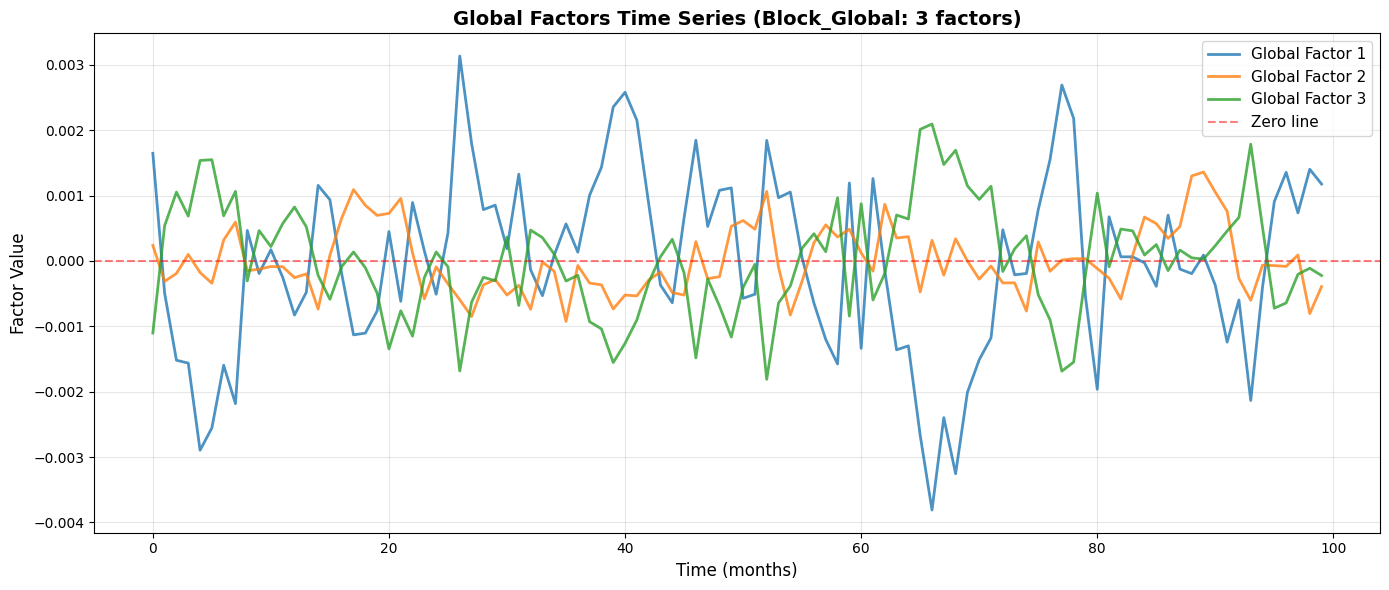


해석:
- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인
- 요인이 양수: 전체적으로 Series들이 상승 추세
- 요인이 음수: 전체적으로 Series들이 하락 추세
- 요인 변화: Series들의 공통 동향 변화

💡 다른 블록 요인도 보고 싶다면:
  - Block_Consumption: 요인 3 ~ 3
  - Block_Investment: 요인 4 ~ ...


In [8]:
# 요인 분석 및 시각화
num_factors = int(np.sum(result.r))  # 총 요인 수
print("=" * 70)
print("요인 분석")
print("=" * 70)
print()
print(f"총 요인 수: {num_factors}")
print(f"요인 시계열 길이: {result.Z.shape[0]}")
print()

# Block_Global의 요인 수 확인 (첫 번째 블록)
block_global_name = config.block_names[0]  # Block_Global이 첫 번째 블록
num_global_factors = config.blocks[block_global_name].factors
print(f"글로벌 요인 (Block_Global): {num_global_factors}개")
print(f"  - 요인 인덱스: 0 ~ {num_global_factors-1}")
print()

# 글로벌 요인만 통계 출력
print("글로벌 요인 통계:")
for j in range(num_global_factors):
    factor_j = result.Z[:, j]
    print(f"  요인 {j+1} (글로벌):")
    print(f"    평균: {np.mean(factor_j):.4f}")
    print(f"    표준편차: {np.std(factor_j):.4f}")
    print(f"    최소값: {np.min(factor_j):.4f}")
    print(f"    최대값: {np.max(factor_j):.4f}")
print()

# 글로벌 요인만 시각화
plt.figure(figsize=(14, 6))
for j in range(num_global_factors):
    factor_j = result.Z[:, j]
    plt.plot(factor_j, linewidth=2, label=f'Global Factor {j+1}', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero line')
plt.title(f'Global Factors Time Series (Block_Global: {num_global_factors} factors)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Factor Value', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인")
print("- 요인이 양수: 전체적으로 Series들이 상승 추세")
print("- 요인이 음수: 전체적으로 Series들이 하락 추세")
print("- 요인 변화: Series들의 공통 동향 변화")
print()
print("💡 다른 블록 요인도 보고 싶다면:")
print(f"  - Block_Consumption: 요인 {num_global_factors} ~ {num_global_factors + config.blocks['Block_Consumption'].factors - 1}")
print(f"  - Block_Investment: 요인 {num_global_factors + config.blocks['Block_Consumption'].factors} ~ ...")


### 5.3 로딩 행렬 분석

로딩 행렬 C는 각 시계열이 각 요인에 얼마나 반응하는지를 나타냅니다.

**해석:**
- 큰 양수 로딩: 시계열이 요인과 같은 방향으로 움직임
- 큰 음수 로딩: 시계열이 요인과 반대 방향으로 움직임
- 작은 로딩: 시계열이 해당 요인에 거의 반응하지 않음

**여러 요인 모델:**
- 각 시계열은 여러 요인의 선형 결합으로 표현됨
- C[i, j] = 시계열 i가 요인 j에 대한 로딩


In [19]:
# 로딩 행렬 분석 (글로벌 요인만)
C = result.C
num_factors = int(np.sum(result.r))

# Block_Global의 요인 수 확인
block_global_name = config.block_names[0]  # Block_Global이 첫 번째 블록
num_global_factors = config.blocks[block_global_name].factors

print("=" * 70)
print("로딩 행렬 분석 (글로벌 요인만)")
print("=" * 70)
print()
print(f"총 요인 수: {num_factors}개")
print(f"글로벌 요인 (Block_Global): {num_global_factors}개 (요인 인덱스: 0 ~ {num_global_factors-1})")
print()

# 글로벌 요인만 로딩 통계
for j in range(num_global_factors):
    C_factor_j = C[:, j]
    print(f"글로벌 요인 {j+1} 로딩 통계:")
    print(f"  평균: {np.mean(C_factor_j):.4f}")
    print(f"  표준편차: {np.std(C_factor_j):.4f}")
    print(f"  최소값: {np.min(C_factor_j):.4f}")
    print(f"  최대값: {np.max(C_factor_j):.4f}")
    print()
    
    # 가장 강하게 로드되는 Series 찾기
    top_5_indices = np.argsort(np.abs(C_factor_j))[-5:][::-1]
    print(f"글로벌 요인 {j+1}에 가장 강하게 로드되는 상위 5개 Series:")
    for i, idx in enumerate(top_5_indices, 1):
        print(f"  {i}. Series {idx}: 로딩 = {C_factor_j[idx]:.4f}")
    print()

# 글로벌 요인만 로딩 시각화
fig, axes = plt.subplots(1, num_global_factors, figsize=(5*num_global_factors, 5))
if num_global_factors == 1:
    axes = [axes]
for j in range(num_global_factors):
    axes[j].bar(range(N), C[:, j], alpha=0.7, color='steelblue')
    axes[j].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[j].set_title(f'Loadings on Global Factor {j+1}', fontsize=12, fontweight='bold')
    axes[j].set_xlabel('Series Index', fontsize=11)
    axes[j].set_ylabel('Loading Value', fontsize=11)
    axes[j].grid(True, alpha=0.3, axis='y')
plt.suptitle(f'Global Factors Loadings (Block_Global: {num_global_factors} factors)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인")
print("- 양수 로딩: 요인이 증가하면 Series도 증가")
print("- 음수 로딩: 요인이 증가하면 Series은 감소")
print("- 절댓값이 클수록: 요인에 더 강하게 반응")
print()
print("💡 다른 블록 요인도 보고 싶다면:")
print(f"  - Block_Consumption: 요인 {num_global_factors} ~ {num_global_factors + config.blocks['Block_Consumption'].factors - 1}")
print(f"  - Block_Investment: 요인 {num_global_factors + config.blocks['Block_Consumption'].factors} ~ ...")


로딩 행렬 분석 (글로벌 요인만)

총 요인 수: 8개
글로벌 요인 (Block_Global): 3개 (요인 인덱스: 0 ~ 2)

글로벌 요인 1 로딩 통계:
  평균: 618.8487
  표준편차: 462.1620
  최소값: -60.9024
  최대값: 2918.6560

글로벌 요인 1에 가장 강하게 로드되는 상위 5개 Series:
  1. Series 73: 로딩 = 2918.6560
  2. Series 69: 로딩 = 2009.2537
  3. Series 77: 로딩 = 1439.7004
  4. Series 39: 로딩 = 1332.6594
  5. Series 78: 로딩 = 1322.5755

글로벌 요인 2 로딩 통계:
  평균: 342.6420
  표준편차: 345.6367
  최소값: -114.1676
  최대값: 1895.4509

글로벌 요인 2에 가장 강하게 로드되는 상위 5개 Series:
  1. Series 73: 로딩 = 1895.4509
  2. Series 69: 로딩 = 1410.0094
  3. Series 35: 로딩 = 1069.1517
  4. Series 77: 로딩 = 895.1123
  5. Series 34: 로딩 = 894.2349

글로벌 요인 3 로딩 통계:
  평균: 145.3255
  표준편차: 330.7006
  최소값: -353.2614
  최대값: 1151.3391

글로벌 요인 3에 가장 강하게 로드되는 상위 5개 Series:
  1. Series 73: 로딩 = 1151.3391
  2. Series 31: 로딩 = 1031.8058
  3. Series 69: 로딩 = 887.5332
  4. Series 80: 로딩 = 806.1737
  5. Series 83: 로딩 = 800.9872


해석:
- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인
- 양수 로딩: 요인이 증가하면 Series도 증가
- 음수 로딩: 요인이 증가하면 Series은 감소
- 절댓값이 클수록

### 5.4 전이 행렬 분석

전이 행렬 A는 요인이 시간에 따라 어떻게 진화하는지를 나타냅니다.

**해석:**
- 대각선 원소: 각 요인의 자기회귀 계수 (AR 계수)
- AR 계수가 1에 가까우면: 요인이 매우 지속적 (느리게 변화)
- AR 계수가 0에 가까우면: 요인이 덜 지속적 (빠르게 변화)
- 고유값 < 1: 요인이 정상적 (stationary)


In [20]:
# 전이 행렬 분석 (글로벌 요인만)
A = result.A
num_factors = int(np.sum(result.r))  # 총 요인 수

# Block_Global의 요인 수 확인
block_global_name = config.block_names[0]  # Block_Global이 첫 번째 블록
num_global_factors = config.blocks[block_global_name].factors

print("=" * 70)
print("전이 행렬 분석 (글로벌 요인만)")
print("=" * 70)
print()
print(f"총 요인 수: {num_factors}개")
print(f"글로벌 요인 (Block_Global): {num_global_factors}개 (요인 인덱스: 0 ~ {num_global_factors-1})")
print()

# 글로벌 요인 부분만 분석
A_global = A[:num_global_factors, :num_global_factors]
A_diag = np.diag(A_global)
print(f"글로벌 요인별 AR 계수 (대각선 원소):")
for i in range(num_global_factors):
    print(f"  글로벌 요인 {i+1}: {A_diag[i]:.4f}")
print()

# 고유값 분석 (글로벌 요인만)
eigenvals = np.linalg.eigvals(A_global)
max_eig = np.max(np.abs(eigenvals))
print(f"고유값 분석 (글로벌 요인):")
print(f"  최대 고유값 (절댓값): {max_eig:.4f}")
print(f"  스펙트럴 반경: {max_eig:.4f}")
if max_eig < 1.0:
    print(f"  ✅ 글로벌 요인이 정상적입니다 (안정적)")
else:
    print(f"  ⚠️ 글로벌 요인이 비정상적일 수 있습니다")
print()

# 전이 행렬 시각화 (글로벌 요인만)
plt.figure(figsize=(10, 8))
im = plt.imshow(A_global, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im, label='Transition Coefficient')
plt.title(f'Global Factors Transition Matrix (Block_Global: {num_global_factors} factors)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Previous Period Factor', fontsize=12)
plt.ylabel('Current Period Factor', fontsize=12)
# 축 레이블에 요인 번호 추가
plt.xticks(range(num_global_factors), [f'Global Factor {i+1}' for i in range(num_global_factors)])
plt.yticks(range(num_global_factors), [f'Global Factor {i+1}' for i in range(num_global_factors)])
# 값 표시
for i in range(num_global_factors):
    for j in range(num_global_factors):
        text = plt.text(j, i, f'{A_global[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인")
print("- AR 계수 > 0.8: 요인이 매우 지속적 (느리게 변화)")
print("- AR 계수 0.5-0.8: 요인이 적당히 지속적")
print("- AR 계수 < 0.5: 요인이 덜 지속적 (빠르게 변화)")
print()
print("💡 다른 블록 요인도 보고 싶다면:")
print(f"  - Block_Consumption: 요인 {num_global_factors} ~ {num_global_factors + config.blocks['Block_Consumption'].factors - 1}")
print(f"  - Block_Investment: 요인 {num_global_factors + config.blocks['Block_Consumption'].factors} ~ ...")


전이 행렬 분석 (글로벌 요인만)

총 요인 수: 8개
글로벌 요인 (Block_Global): 3개 (요인 인덱스: 0 ~ 2)

글로벌 요인별 AR 계수 (대각선 원소):
  글로벌 요인 1: 0.3585
  글로벌 요인 2: 0.1159
  글로벌 요인 3: 0.0827

고유값 분석 (글로벌 요인):
  최대 고유값 (절댓값): 0.4193
  스펙트럴 반경: 0.4193
  ✅ 글로벌 요인이 정상적입니다 (안정적)


해석:
- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인
- AR 계수 > 0.8: 요인이 매우 지속적 (느리게 변화)
- AR 계수 0.5-0.8: 요인이 적당히 지속적
- AR 계수 < 0.5: 요인이 덜 지속적 (빠르게 변화)

💡 다른 블록 요인도 보고 싶다면:
  - Block_Consumption: 요인 3 ~ 3
  - Block_Investment: 요인 4 ~ ...


### 5.5 혁신 공분산 행렬 분석

혁신 공분산 행렬 Q는 요인 혁신의 분산을 나타냅니다.

**해석:**
- 대각선 원소: 각 요인의 혁신 분산
- 큰 분산: 요인이 예측하기 어려움 (변동성이 큼)
- 작은 분산: 요인이 예측하기 쉬움 (변동성이 작음)
- v0.2.5 개선: 요인 혁신 분산의 최소값이 0.01로 설정되어 스케일 문제 방지


In [21]:
# 혁신 공분산 행렬 분석 (블록별 비교)
Q = result.Q
Q_diag = np.diag(Q)
num_factors = int(np.sum(result.r))

# 블록별 요인 인덱스 계산
block_factor_ranges = {}
factor_idx = 0
for block_name in config.block_names:
    num_block_factors = config.blocks[block_name].factors
    block_factor_ranges[block_name] = (factor_idx, factor_idx + num_block_factors)
    factor_idx += num_block_factors

print("=" * 70)
print("혁신 공분산 행렬 분석 (블록별 비교)")
print("=" * 70)
print()
print(f"총 요인 수: {num_factors}개")
print()

# 블록별 통계 수집
block_stats = []
for block_name in config.block_names:
    start_idx, end_idx = block_factor_ranges[block_name]
    Q_block_diag = Q_diag[start_idx:end_idx]
    mean_val = np.mean(Q_block_diag)
    min_val = np.min(Q_block_diag)
    max_val = np.max(Q_block_diag)
    block_stats.append({
        'name': block_name.replace('Block_', ''),
        'n_factors': end_idx - start_idx,
        'mean': mean_val,
        'min': min_val,
        'max': max_val
    })
    print(f"{block_name} ({end_idx - start_idx}개 요인): 평균={mean_val:.6f}, "
          f"최소={min_val:.6f}, 최대={max_val:.6f}")
print()

# v0.2.5 개선사항 확인
Q_min_factor = 0.01
Q_factor_diag = Q_diag[:num_factors]
if np.all(Q_factor_diag >= Q_min_factor):
    print(f"✅ Q 행렬 Floor 적용 확인: 모든 요인 분산 >= {Q_min_factor}")
else:
    print(f"⚠️ 일부 요인 분산이 Floor보다 작음")
print()

# 간단한 바 차트 (블록별 평균)
fig, ax = plt.subplots(figsize=(10, 6))

colors_map = {
    'Global': 'steelblue',
    'Consumption': 'coral',
    'Investment': 'mediumseagreen',
    'Export': 'gold',
    'Labor': 'orchid',
    'Nominal': 'lightcoral'
}

block_names_short = [s['name'] for s in block_stats]
block_means = [s['mean'] for s in block_stats]
bar_colors = [colors_map.get(name, 'gray') for name in block_names_short]

bars = ax.bar(block_names_short, block_means, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1)
ax.axhline(y=Q_min_factor, color='r', linestyle='--', linewidth=2, 
          label=f'Floor ({Q_min_factor})', alpha=0.8)

# 값 표시
for i, (bar, mean_val) in enumerate(zip(bars, block_means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean_val:.4f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_title('Factor Innovation Variance by Block (Average)', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Block', fontsize=12)
ax.set_ylabel('Innovation Variance (Average)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n해석:")
print("- Innovation Variance: 요인 혁신의 분산 (요인이 얼마나 변동적인지)")
print("- 큰 분산: 요인이 Forecast하기 어려움 (높은 불확실성)")
print("- 작은 분산: 요인이 Forecast하기 쉬움 (낮은 불확실성)")
print("- Floor 설정: 수치적 안정성 보장 (v0.2.5 개선사항)")


혁신 공분산 행렬 분석 (블록별 비교)

총 요인 수: 8개

Block_Global (3개 요인): 평균=0.010002, 최소=0.010002, 최대=0.010004
Block-Export (1개 요인): 평균=0.010000, 최소=0.010000, 최대=0.010000
Block-Labor (1개 요인): 평균=0.010000, 최소=0.010000, 최대=0.010000
Block-Nominal (1개 요인): 평균=0.010000, 최소=0.010000, 최대=0.010000
Block_Consumption (1개 요인): 평균=0.010000, 최소=0.010000, 최대=0.010000
Block_Investment (1개 요인): 평균=0.010000, 최소=0.010000, 최대=0.010000

✅ Q 행렬 Floor 적용 확인: 모든 요인 분산 >= 0.01


해석:
- Innovation Variance: 요인 혁신의 분산 (요인이 얼마나 변동적인지)
- 큰 분산: 요인이 Forecast하기 어려움 (높은 불확실성)
- 작은 분산: 요인이 Forecast하기 쉬움 (낮은 불확실성)
- Floor 설정: 수치적 안정성 보장 (v0.2.5 개선사항)


### 5.6 관측 오차 공분산 행렬 분석

관측 오차 공분산 행렬 R은 특이 성분(idiosyncratic component)의 분산을 나타냅니다.

**해석:**
- 대각선 원소: 각 시계열의 특이 분산
- 작은 분산: 시계열이 요인으로 잘 설명됨 (요인 설명력 높음)
- 큰 분산: 시계열이 요인으로 잘 설명되지 않음 (요인 설명력 낮음)


관측 오차 공분산 행렬 분석

Idiosyncratic Variance 통계:
  최소Value: 0.219612
  평균Value: 4.741329
  최대Value: 9.920886
  중앙Value: 3.643841

요인 설명력 (1 - R[i,i] / Var(y[i])):
  평균: -105.74%
  최소: -2747.34%
  최대: 93.91%



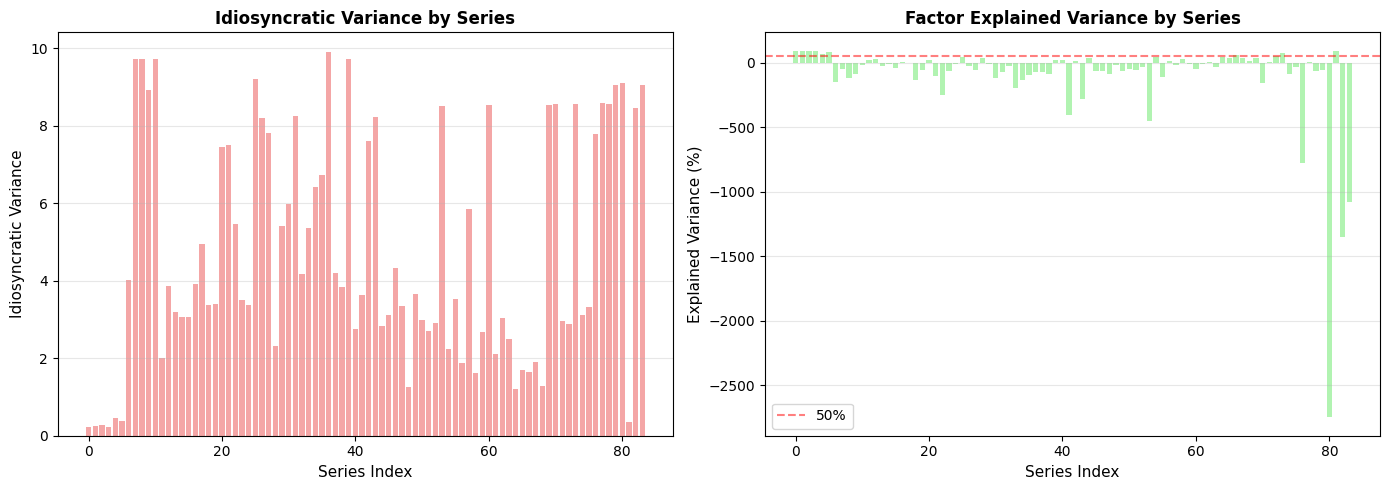


해석:
- 작은 Idiosyncratic Variance: Series이 요인으로 잘 설명됨
- 큰 Idiosyncratic Variance: Series이 요인으로 잘 설명되지 않음
- 높은 설명력: 요인이 Series 변동의 대부분을 설명


In [12]:
# 관측 오차 공분산 행렬 분석
R = result.R
R_diag = np.diag(R)

print("=" * 70)
print("관측 오차 공분산 행렬 분석")
print("=" * 70)
print()

print(f"Idiosyncratic Variance 통계:")
print(f"  최소Value: {np.min(R_diag):.6f}")
print(f"  평균Value: {np.mean(R_diag):.6f}")
print(f"  최대Value: {np.max(R_diag):.6f}")
print(f"  중앙Value: {np.median(R_diag):.6f}")
print()

# 요인 설명력 계산
# 설명력 = 1 - (Idiosyncratic Variance / 전체 분산)
X_sm = result.X_sm
explained_var = []
for i in range(N):
    var_total = np.var(X_sm[:, i])
    var_idio = R_diag[i]
    if var_total > 0:
        explained = 1 - (var_idio / var_total)
        explained_var.append(explained)
    else:
        explained_var.append(0.0)

explained_var = np.array(explained_var)
print(f"요인 설명력 (1 - R[i,i] / Var(y[i])):")
print(f"  평균: {np.mean(explained_var):.2%}")
print(f"  최소: {np.min(explained_var):.2%}")
print(f"  최대: {np.max(explained_var):.2%}")
print()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Idiosyncratic Variance
axes[0].bar(range(N), R_diag, alpha=0.7, color='lightcoral')
axes[0].set_title('Idiosyncratic Variance by Series', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Series Index', fontsize=11)
axes[0].set_ylabel('Idiosyncratic Variance', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# 요인 설명력
axes[1].bar(range(N), explained_var * 100, alpha=0.7, color='lightgreen')
axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%')
axes[1].set_title('Factor Explained Variance by Series', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Series Index', fontsize=11)
axes[1].set_ylabel('Explained Variance (%)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n해석:")
print("- 작은 Idiosyncratic Variance: Series이 요인으로 잘 설명됨")
print("- 큰 Idiosyncratic Variance: Series이 요인으로 잘 설명되지 않음")
print("- 높은 설명력: 요인이 Series 변동의 대부분을 설명")


### 5.7 요인 재구성 및 검증

요인과 로딩을 사용하여 원본 시계열을 재구성하고 실제 데이터와 비교해봅니다.


데이터 크기 확인:
  X shape: (100, 84), actual length: 100
  result.Z shape: (100, 148), Z_factors shape: (100, 8)
  reconstructed shape: (100, 84), recon length: 100
  result.X_sm shape: (100, 84), smoothed length: 100

Series 0 재구성 검증

Factor Reconstruction 상관계수: 0.7047
Smoothed Data 상관계수: 0.9070



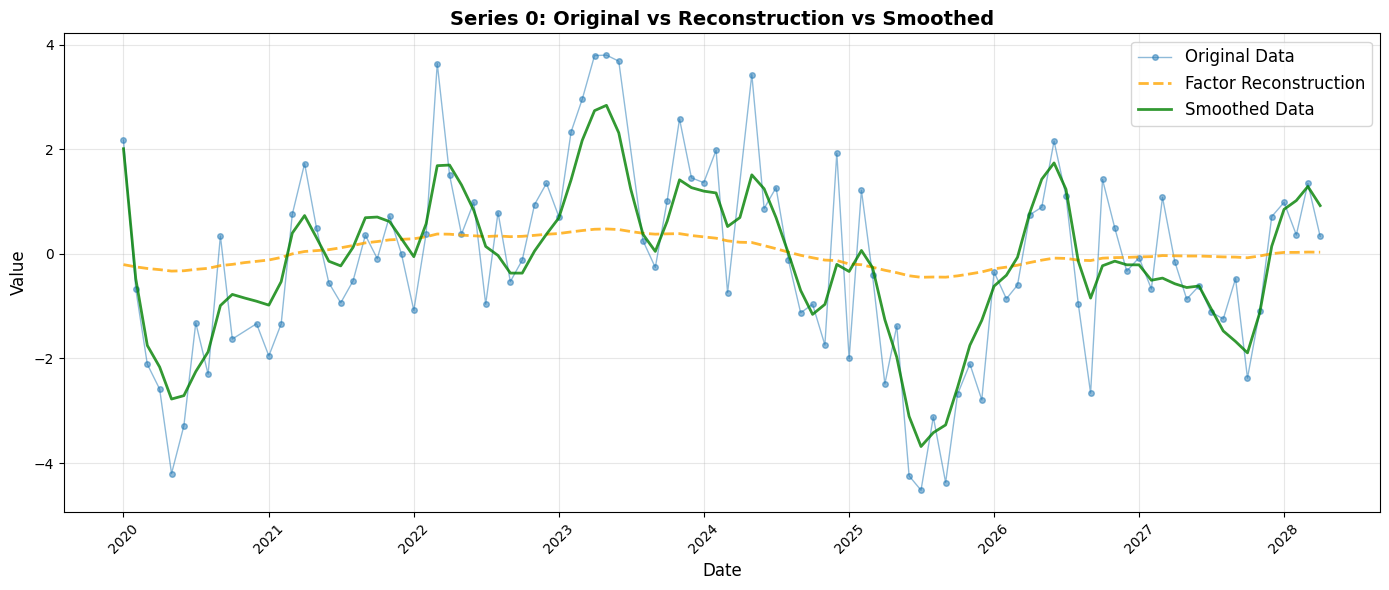


해석:
- Factor Reconstruction: 요인만 사용한 재구성 (특이 성분 제외)
- Smoothed Data: 요인 + 특이 성분 (Kalman smoother 결과)
- 높은 상관계수: 모델이 데이터를 잘 설명함


In [13]:
# 요인을 사용한 Series 재구성
# 재구성Value = C @ Z^T (요인 성분만)
# result.Z는 이미 (T x m) 크기로 t=1부터 T까지의 요인을 포함
Z = result.Z  # (T, m) - 이미 t=1부터 T까지 (초기 상태 Z_0 제외됨)
num_factors = int(np.sum(result.r))  # 요인 수
# Z에서 요인 부분만 추출 (Z는 전체 상태 벡터: 요인 + idiosyncratic components)
Z_factors = Z[:, :num_factors]  # 요인 부분만 (T, num_factors)
# 재구성: (T, num_factors) @ (num_factors, N) = (T, N)
reconstructed = Z_factors @ C[:, :num_factors].T  # 요인 부분만 사용

# 특정 Series 선택 (예: 첫 번째 Series)
series_idx = 0
actual = X[:, series_idx]  # (T,) - t=1부터 T까지
recon = reconstructed[:, series_idx]  # (T,) - t=1부터 T까지
smoothed = result.X_sm[:, series_idx]  # (T,) - t=1부터 T까지

# 크기 확인 (디버깅용)
print(f"데이터 크기 확인:")
print(f"  X shape: {X.shape}, actual length: {len(actual)}")
print(f"  result.Z shape: {result.Z.shape}, Z_factors shape: {Z_factors.shape}")
print(f"  reconstructed shape: {reconstructed.shape}, recon length: {len(recon)}")
print(f"  result.X_sm shape: {result.X_sm.shape}, smoothed length: {len(smoothed)}")
print()

# 결측치 제외하고 비교
# 모든 데이터는 같은 크기 (T,)이므로 추가 인덱싱 불필요
valid_mask = ~np.isnan(actual)
actual_valid = actual[valid_mask]
recon_valid = recon[valid_mask]
smoothed_valid = smoothed[valid_mask]

# 상관계수 계산
corr_recon = np.corrcoef(actual_valid, recon_valid)[0, 1]
corr_smoothed = np.corrcoef(actual_valid, smoothed_valid)[0, 1]

print("=" * 70)
print(f"Series {series_idx} 재구성 검증")
print("=" * 70)
print()
print(f"Factor Reconstruction 상관계수: {corr_recon:.4f}")
print(f"Smoothed Data 상관계수: {corr_smoothed:.4f}")
print()

from dfm_python.core.time import datetime_range
from datetime import datetime
data_length = len(actual)
time_index = np.asarray(
    datetime_range(start=datetime(2020, 1, 1), periods=data_length, freq='ME')  # ME = Month End
)

# 시각화
plt.figure(figsize=(14, 6))

# Original Data: 결측치가 있는 부분은 마커만 표시하고 선은 끊김
actual_plot = actual.copy()
actual_valid_mask = ~np.isnan(actual_plot)
plt.plot(time_index[actual_valid_mask], actual_plot[actual_valid_mask], 'o-', 
         alpha=0.5, label='Original Data', markersize=4, linewidth=1)

# Factor Reconstruction과 Smoothed Data는 결측치가 없으므로 연속 선으로 표시
plt.plot(time_index, recon, '--', linewidth=2, label='Factor Reconstruction', alpha=0.8, color='orange')
plt.plot(time_index, smoothed, '-', linewidth=2, label='Smoothed Data', alpha=0.8, color='green')

plt.title(f'Series {series_idx}: Original vs Reconstruction vs Smoothed', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # 날짜 레이블 회전
plt.tight_layout()
plt.show()

print("\n해석:")
print("- Factor Reconstruction: 요인만 사용한 재구성 (특이 성분 제외)")
print("- Smoothed Data: 요인 + 특이 성분 (Kalman smoother 결과)")
print("- 높은 상관계수: 모델이 데이터를 잘 설명함")


## 6. 예측 및 시각화

### 6.1 미래 예측

학습된 모델을 사용하여 미래 값을 예측합니다.


💡 Note: 실제 사용 시에는 horizon=None (1년) 또는 더 큰 값을 사용하세요.
Forecast 결과 (글로벌 요인만)

Forecast 기간: 12개월
Forecast된 Series 크기: (12, 84)
Forecast된 요인 크기: (12, 148)
글로벌 요인 (Block_Global): 3개 (요인 인덱스: 0 ~ 2)



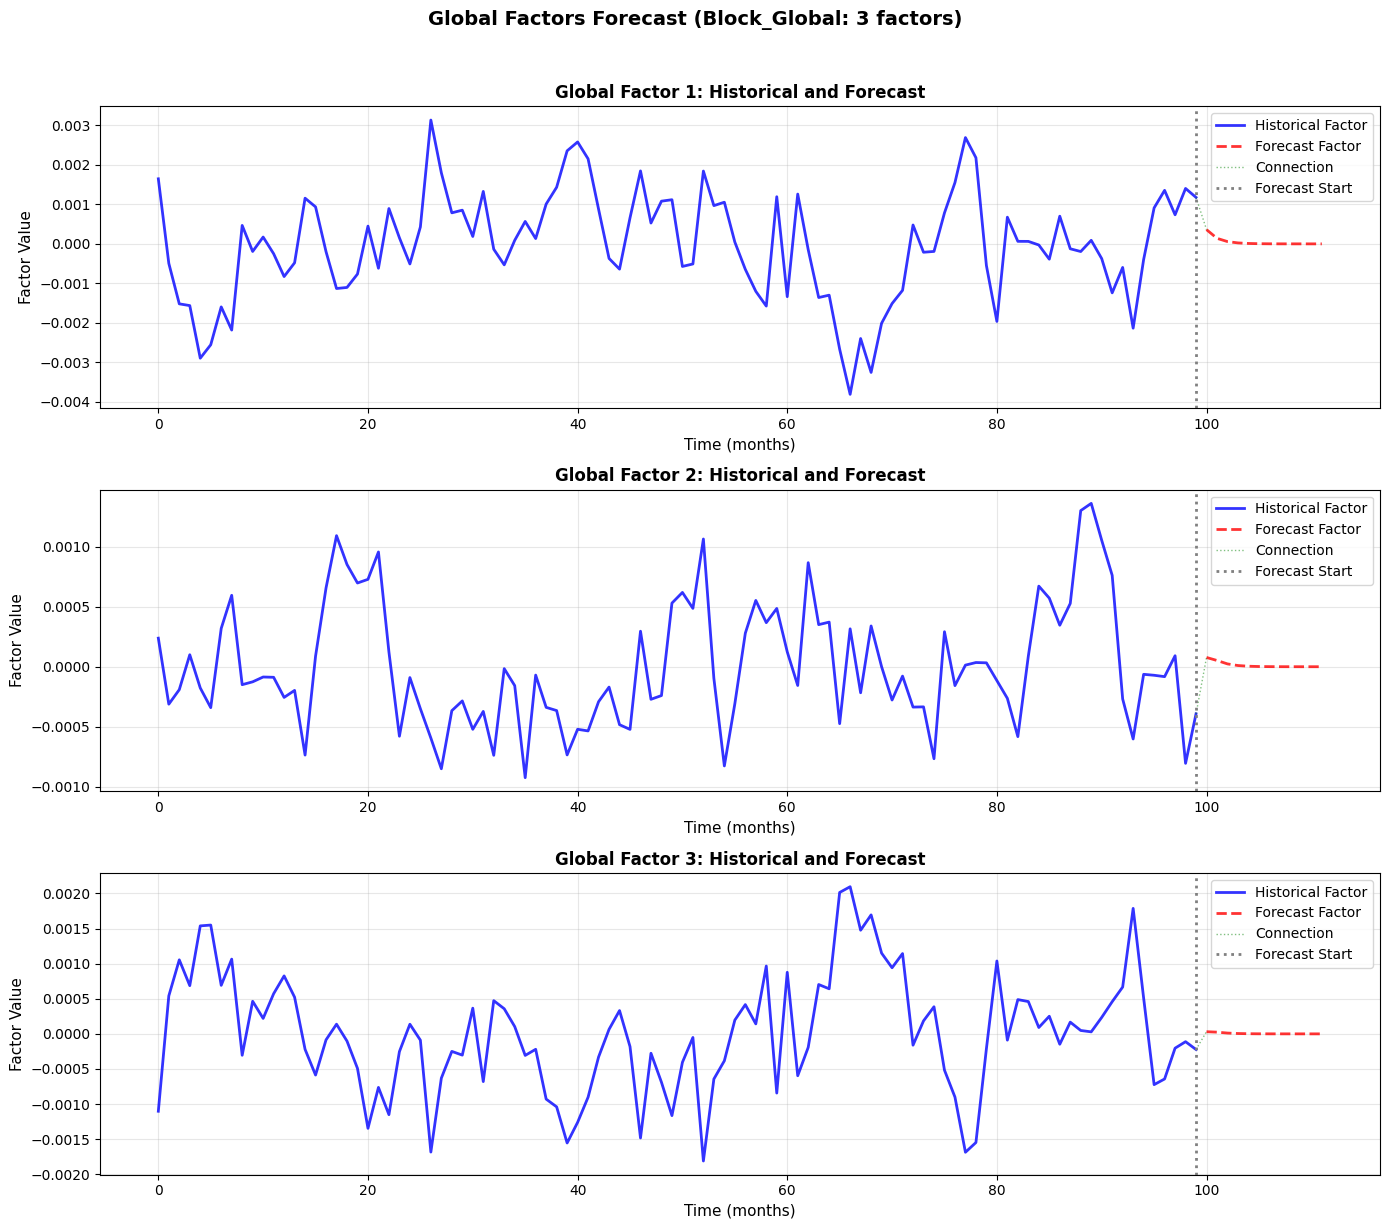


해석:
- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인
- Historical Factor: Kalman smoother로 추정된 값
- Forecast Factor: 전이 행렬 A를 사용한 확정적 Forecast
- Forecast 방법: Z_{t+h} = A^h @ Z_t

💡 다른 블록 요인도 Forecast하고 싶다면:
  - Block_Consumption: 요인 3 ~ 3
  - Block_Investment: 요인 4 ~ ...


In [14]:
# Forecast 수행 (12개월 forecast)
horizon = 12  # 12개월 forecast
# model.predict() 메서드 사용 (DFM 클래스의 메서드)
X_forecast, Z_forecast = model.predict(horizon=horizon)
print(f"💡 Note: 실제 사용 시에는 horizon=None (1년) 또는 더 큰 값을 사용하세요.")

# Block_Global의 요인 수 확인
block_global_name = config.block_names[0]  # Block_Global이 첫 번째 블록
num_global_factors = config.blocks[block_global_name].factors

print("=" * 70)
print("Forecast 결과 (글로벌 요인만)")
print("=" * 70)
print()
print(f"Forecast 기간: {horizon}개월")
print(f"Forecast된 Series 크기: {X_forecast.shape}")
print(f"Forecast된 요인 크기: {Z_forecast.shape}")
print(f"글로벌 요인 (Block_Global): {num_global_factors}개 (요인 인덱스: 0 ~ {num_global_factors-1})")
print()

# 글로벌 요인만 Forecast 시각화
fig, axes = plt.subplots(num_global_factors, 1, figsize=(14, 4*num_global_factors))
if num_global_factors == 1:
    axes = [axes]
for j in range(num_global_factors):
    # Historical Factor (전체 historical 포함하여 자연스럽게 이어지도록)
    past_factor = result.Z[:, j]  # Z[0]부터 Z[T-1]까지 전체 포함
    past_time = np.arange(len(past_factor))
    # Forecast Factor
    forecast_factor = Z_forecast[:, j]
    forecast_time = np.arange(len(past_factor), len(past_factor) + len(forecast_factor))
    
    # Historical과 Forecast를 자연스럽게 연결하기 위해 마지막 값과 첫 값을 연결
    axes[j].plot(past_time, past_factor, 'b-', linewidth=2, label='Historical Factor', alpha=0.8)
    axes[j].plot(forecast_time, forecast_factor, 'r--', linewidth=2, label='Forecast Factor', alpha=0.8)
    # 연결점 표시: 마지막 historical 값과 첫 forecast 값을 연결
    if len(past_factor) > 0 and len(forecast_factor) > 0:
        axes[j].plot([past_time[-1], forecast_time[0]], 
                    [past_factor[-1], forecast_factor[0]], 
                    'g-', linewidth=1, alpha=0.5, linestyle=':', label='Connection')
    axes[j].axvline(x=len(past_factor)-1, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
    axes[j].set_title(f'Global Factor {j+1}: Historical and Forecast', fontsize=12, fontweight='bold')
    axes[j].set_xlabel('Time (months)', fontsize=11)
    axes[j].set_ylabel('Factor Value', fontsize=11)
    axes[j].legend(fontsize=10)
    axes[j].grid(True, alpha=0.3)
plt.suptitle(f'Global Factors Forecast (Block_Global: {num_global_factors} factors)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 글로벌 요인: 모든 시리즈에 공통으로 영향을 미치는 요인")
print("- Historical Factor: Kalman smoother로 추정된 값")
print("- Forecast Factor: 전이 행렬 A를 사용한 확정적 Forecast")
print("- Forecast 방법: Z_{t+h} = A^h @ Z_t")
print()
print("💡 다른 블록 요인도 Forecast하고 싶다면:")
print(f"  - Block_Consumption: 요인 {num_global_factors} ~ {num_global_factors + config.blocks['Block_Consumption'].factors - 1}")
print(f"  - Block_Investment: 요인 {num_global_factors + config.blocks['Block_Consumption'].factors} ~ ...")


### 6.2 시계열 예측 시각화

특정 시계열의 예측 결과를 시각화합니다.


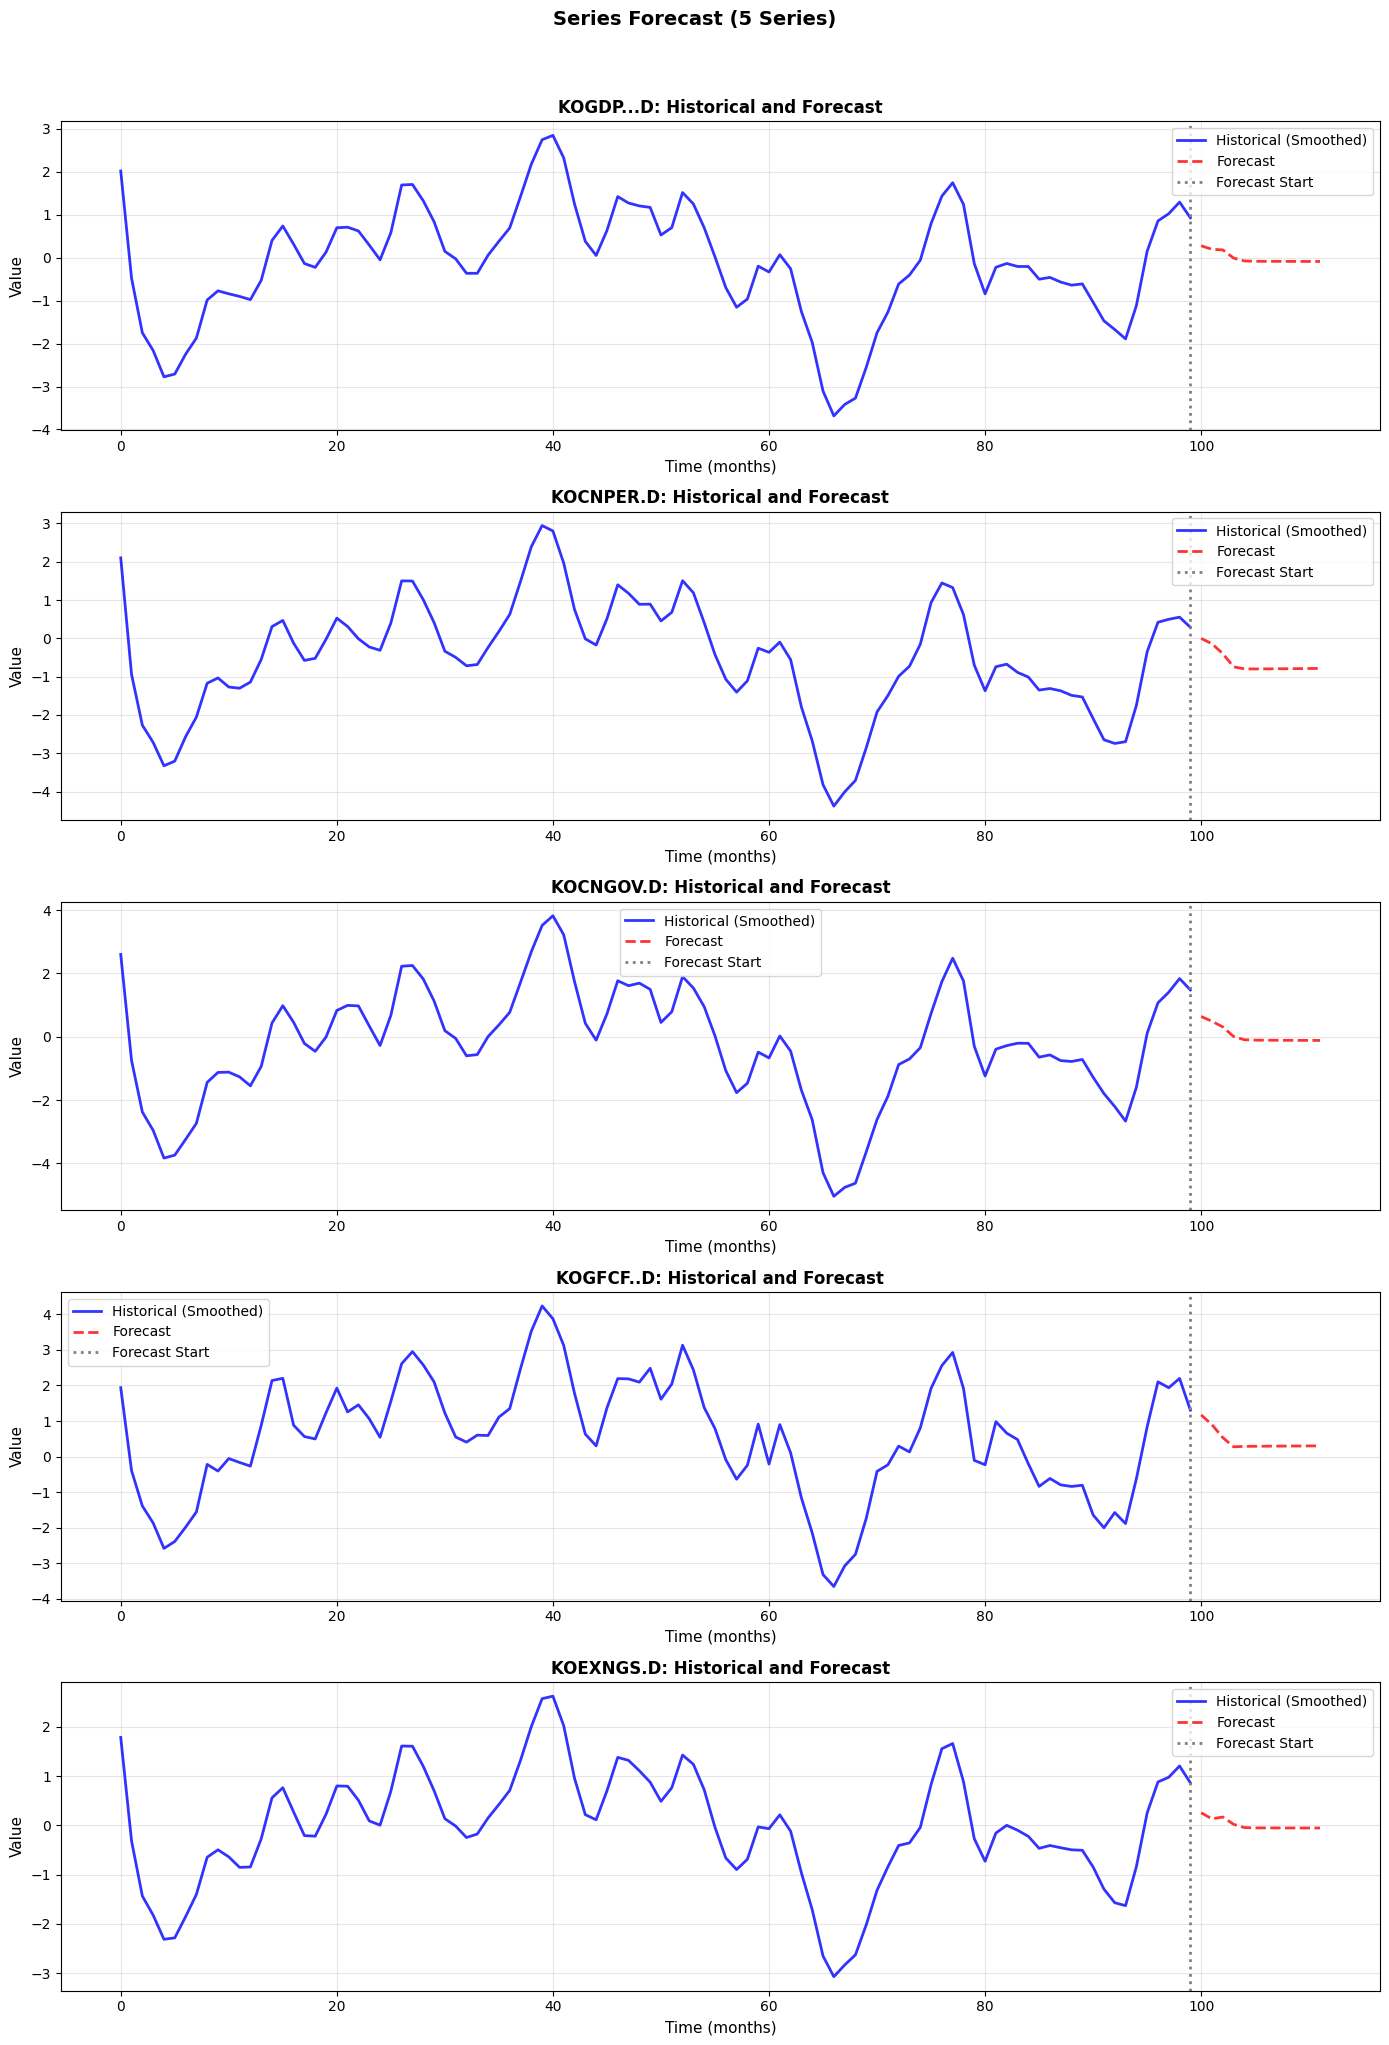

In [15]:
# 특정 Series Forecast 시각화 (5개 시리즈를 5x1 subplot으로)
num_series_to_plot = 5
series_indices = list(range(num_series_to_plot))

# Get series names from config
series_names = []
for idx in series_indices:
    if config is not None and idx < len(config.series):
        series_name = config.series[idx].series_id
    else:
        series_name = f"Series {idx}"
    series_names.append(series_name)

# Create 5x1 subplot
fig, axes = plt.subplots(num_series_to_plot, 1, figsize=(14, 4*num_series_to_plot))
if num_series_to_plot == 1:
    axes = [axes]

for i, series_idx in enumerate(series_indices):
    # 과거 데이터
    past_data = result.X_sm[:, series_idx]
    past_time = np.arange(len(past_data))
    # Forecast 데이터
    forecast_data = X_forecast[:, series_idx]
    forecast_time = np.arange(len(past_data), len(past_data) + len(forecast_data))
    
    # Plot
    axes[i].plot(past_time, past_data, 'b-', linewidth=2, label='Historical (Smoothed)', alpha=0.8)
    axes[i].plot(forecast_time, forecast_data, 'r--', linewidth=2, label='Forecast', alpha=0.8)
    axes[i].axvline(x=len(past_data)-1, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
    axes[i].set_title(f'{series_names[i]}: Historical and Forecast', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Time (months)', fontsize=11)
    axes[i].set_ylabel('Value', fontsize=11)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Series Forecast (5 Series)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 7. Nowcasting 및 News Decomposition

### 7.1 Nowcasting 기본 사용법

Nowcasting은 공식 발표 전 현재 시점의 경제 지표를 추정하는 기능입니다.

**v0.3.0 개선사항:**
- `NowcastResult` dataclass: 구조화된 결과 반환
- `return_result` 파라미터: 간단한 float 또는 전체 결과 객체 선택
- 데이터 가용성, 요인 값, DFM 결과 등 메타데이터 포함


In [16]:
# Nowcasting 예제
from dfm_python.nowcast import NowcastResult
from dfm_python.core.time import get_latest_time

# Get Nowcast instance
nowcast = model.nowcast

# Get target series (first series in config)
if config is not None and len(config.series) > 0:
    target_series = config.series[0].series_id
else:
    target_series = None

# Get latest date from model time
if hasattr(model, 'time') and model.time is not None:
    try:
        latest_date = get_latest_time(model.time)
    except Exception:
        latest_date = None
else:
    latest_date = None

print("=" * 70)
print("Nowcasting 예제")
print("=" * 70)
print()

if latest_date is not None and target_series is not None:
    try:
        # Simple nowcast (returns float)
        print("1. 간단한 Nowcast (float 반환):")
        nowcast_value = nowcast(
            target_series=target_series,
            view_date=latest_date,
            return_result=False  # Default: return float
        )
        print(f"   Nowcast 값: {nowcast_value:.4f}")
        print()
        
        # Full nowcast result (returns NowcastResult)
        print("2. 전체 Nowcast 결과 (NowcastResult 반환):")
        nowcast_result = nowcast(
            target_series=target_series,
            view_date=latest_date,
            return_result=True  # Return full result object
        )
        if isinstance(nowcast_result, NowcastResult):
            print(f"   Nowcast 값: {nowcast_result.nowcast_value:.4f}")
            print(f"   Target series: {nowcast_result.target_series}")
            print(f"   View date: {nowcast_result.view_date}")
            print(f"   Target period: {nowcast_result.target_period}")
            if nowcast_result.data_availability:
                print(f"   데이터 가용성:")
                print(f"     - 사용 가능: {nowcast_result.data_availability['n_available']}개")
                print(f"     - 결측치: {nowcast_result.data_availability['n_missing']}개")
            if nowcast_result.factors_at_view is not None:
                print(f"   요인 값 (view 시점): {nowcast_result.factors_at_view[:3]}... (처음 3개)")
        print()
        
    except Exception as e:
        print(f"⚠️ Nowcast 계산 실패: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ Time index 또는 target series가 없어 nowcast를 수행할 수 없습니다.")


Nowcasting 예제

1. 간단한 Nowcast (float 반환):
   Nowcast 값: 0.3351

2. 전체 Nowcast 결과 (NowcastResult 반환):
   Nowcast 값: 0.3351
   Target series: KOGDP...D
   View date: 2028-04-01 00:00:00
   Target period: 2028-04-01 00:00:00
   데이터 가용성:
     - 사용 가능: 7991개
     - 결측치: 409개
   요인 값 (view 시점): [ 0.00117689 -0.00039226 -0.00022302]... (처음 3개)



### 7.2 News Decomposition

News Decomposition은 새로운 데이터 발표가 예측에 미치는 영향을 분석하는 기능입니다.

**v0.3.0 개선사항:**
- `NewsDecompResult` dataclass: 구조화된 결과 반환
- `return_dict` 파라미터: 하위 호환성을 위한 딕셔너리 반환 옵션
- Top contributors 자동 계산


In [22]:
# News Decomposition 예제
from dfm_python.nowcast import NewsDecompResult

if latest_date is not None and target_series is not None and hasattr(model, 'time') and model.time is not None:
    try:
        # Get two different view dates for comparison
        time_len = len(model.time) if hasattr(model.time, '__len__') else 0
        if time_len >= 2:
            # Convert TimeIndex elements to datetime if needed
            if time_len >= 5:
                view_date_old_raw = model.time[-5]
            else:
                view_date_old_raw = model.time[0]
            
            # Convert to datetime if needed
            if isinstance(view_date_old_raw, datetime):
                view_date_old = view_date_old_raw
            else:
                from dfm_python.core.time import to_python_datetime
                view_date_old = to_python_datetime(view_date_old_raw)
            
            view_date_new = latest_date
            
            print("=" * 70)
            print("News Decomposition 예제")
            print("=" * 70)
            print()
            print(f"Target series: {target_series}")
            print(f"Old view date: {view_date_old}")
            print(f"New view date: {view_date_new}")
            print()
            
            # News decomposition (returns NewsDecompResult by default)
            news = nowcast.decompose(
                target_series=target_series,
                target_period=latest_date,
                view_date_old=view_date_old,
                view_date_new=view_date_new,
                return_dict=False  # Default: return NewsDecompResult
            )
            
            if isinstance(news, NewsDecompResult):
                print("News Decomposition 결과:")
                print(f"  - 이전 예측: {news.y_old:.4f}")
                print(f"  - 새로운 예측: {news.y_new:.4f}")
                print(f"  - 변화량: {news.change:.4f}")
                print()
                
                if len(news.top_contributors) > 0:
                    print("  - 주요 기여 시리즈 (Top 5):")
                    for i, (series_id, impact) in enumerate(news.top_contributors[:5], 1):
                        print(f"    {i}. {series_id}: {impact:.4f}")
                print()
            
            # Dictionary format (backward compatibility)
            news_dict = nowcast.decompose(
                target_series=target_series,
                target_period=latest_date,
                view_date_old=view_date_old,
                view_date_new=view_date_new,
                return_dict=True  # Return dictionary
            )
            if isinstance(news_dict, dict):
                print("💡 Dictionary 형식도 지원됩니다 (하위 호환성):")
                print(f"   Keys: {list(news_dict.keys())}")
            
    except Exception as e:
        print(f"⚠️ News decomposition 실패: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ Time index 또는 target series가 없어 news decomposition을 수행할 수 없습니다.")


News Decomposition 예제

Target series: KOGDP...D
Old view date: 2027-12-01 00:00:00
New view date: 2028-04-01 00:00:00

News Decomposition 결과:
  - 이전 예측: 0.9243
  - 새로운 예측: 0.3351
  - 변화량: -0.5892

  - 주요 기여 시리즈 (Top 5):
    1. KOGDP...D: -0.5892
    2. KOCSEOHDR: 0.0000
    3. KOCSEMEMR: 0.0000
    4. KOCSEOHSR: 0.0000
    5. KOCSECDMR: 0.0000

💡 Dictionary 형식도 지원됩니다 (하위 호환성):
   Keys: ['y_old', 'y_new', 'change', 'singlenews', 'top_contributors', 'actual', 'forecast', 'weight', 't_miss', 'v_miss', 'innov']


## 8. Backtesting

### 7.1 Pseudo Real-Time Backtesting

Backtesting은 pseudo real-time 환경에서 모델 성능을 평가하는 기능입니다.

**v0.3.0 주요 기능:**
- `backtest()` 메서드: 여러 backward step에 대한 nowcast 계산
- `BacktestResult` dataclass: 구조화된 결과 및 메트릭
- `plot()` 메서드: Point-wise 메트릭 시각화
- `higher_freq` 옵션: Clock보다 한 단계 빠른 주파수 사용
- 자동 에러 처리 및 실패한 step 추적


In [18]:
# Backtesting 예제
from dfm_python.nowcast import BacktestResult

if latest_date is not None and target_series is not None:
    try:
        print("=" * 70)
        print("Backtesting 예제")
        print("=" * 70)
        print()
        
        # Perform backtest (minimal steps for quick demo)
        backtest_result = nowcast.backtest(
            target_series=target_series,
            target_date=latest_date,
            backward_steps=2,  # Minimal: 2 steps for quick demo
            higher_freq=False,  # Use clock frequency
            include_actual=True  # Compare with actual values
        )
        
        print("Backtest 결과:")
        print(f"  - Target series: {backtest_result.target_series}")
        print(f"  - Target date: {backtest_result.target_date}")
        print(f"  - Backward steps: {backtest_result.backward_steps}")
        print(f"  - Backward frequency: {backtest_result.backward_freq}")
        print(f"  - Higher frequency mode: {backtest_result.higher_freq}")
        print()
        
        # Overall metrics
        if backtest_result.overall_rmse is not None:
            print("  - 전체 메트릭:")
            print(f"    * RMSE: {backtest_result.overall_rmse:.4f}")
            print(f"    * MAE: {backtest_result.overall_mae:.4f}")
            print(f"    * MSE: {backtest_result.overall_mse:.4f}")
        print()
        
        # Point-wise metrics
        print("  - Point-wise 메트릭 (각 step별):")
        for i in range(backtest_result.backward_steps):
            if not np.isnan(backtest_result.rmse_per_step[i]):
                print(f"    Step {i}: RMSE={backtest_result.rmse_per_step[i]:.4f}, "
                      f"MAE={backtest_result.mae_per_step[i]:.4f}")
        print()
        
        # Failed steps
        if len(backtest_result.failed_steps) > 0:
            print(f"  - 실패한 steps: {backtest_result.failed_steps}")
        else:
            print("  - 모든 steps 성공")
        print()
        
        # Individual nowcast results
        print("  - 개별 Nowcast 결과 (처음 2개):")
        for i, nowcast_res in enumerate(backtest_result.nowcast_results[:2]):
            print(f"    Step {i}:")
            print(f"      * Nowcast: {nowcast_res.nowcast_value:.4f}")
            print(f"      * View date: {nowcast_res.view_date}")
            if nowcast_res.data_availability:
                print(f"      * Data available: {nowcast_res.data_availability['n_available']}개")
        print()
        
        # News decomposition between steps
        print("  - News Decomposition (step 간):")
        for i, news_res in enumerate(backtest_result.news_results[:2]):
            if news_res is not None:
                print(f"    Step {i}: Forecast change = {news_res.change:.4f}")
            elif i == 0:
                print(f"    Step {i}: 첫 번째 step (이전 view 없음)")
        print()
        
        # Visualize results
        try:
            import matplotlib
            matplotlib.use('Agg')  # Non-interactive backend
            
            print("  - 메트릭 시각화:")
            backtest_result.plot(save_path='backtest_results.png', show=False)
            print("    * Plot saved to: backtest_results.png")
        except Exception as e:
            print(f"    * Plot 생성 실패: {e}")
        
        print()
        print("💡 Note: 실제 사용 시에는 backward_steps=20~50을 권장합니다.")
        
    except Exception as e:
        print(f"⚠️ Backtesting 실패: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ Time index가 없어 backtesting을 수행할 수 없습니다.")


Backtesting 예제

Backtest 결과:
  - Target series: KOGDP...D
  - Target date: 2028-04-01 00:00:00
  - Backward steps: 2
  - Backward frequency: m
  - Higher frequency mode: False

  - 전체 메트릭:
    * RMSE: 0.0000
    * MAE: 0.0000
    * MSE: 0.0000

  - Point-wise 메트릭 (각 step별):
    Step 0: RMSE=0.0000, MAE=0.0000
    Step 1: RMSE=0.0000, MAE=0.0000

  - 모든 steps 성공

  - 개별 Nowcast 결과 (처음 2개):
    Step 0:
      * Nowcast: 0.3351
      * View date: 2028-03-01 00:00:00
      * Data available: 7991개
    Step 1:
      * Nowcast: 0.3351
      * View date: 2028-04-01 00:00:00
      * Data available: 7991개

  - News Decomposition (step 간):
    Step 0: 첫 번째 step (이전 view 없음)
    Step 1: Forecast change = -0.5892

  - 메트릭 시각화:
    * Plot saved to: backtest_results.png

💡 Note: 실제 사용 시에는 backward_steps=20~50을 권장합니다.


### 8.1 Backtest 결과 시각화
backtest 단계에서 저장한 메트릭 그래프를 노트북 내에서도 바로 확인할 수 있도록 시각화를 추가합니다.


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

print("= Backtest Visualization =")
if 'backtest_result' in locals() and backtest_result is not None:
    backtest_result.plot(show=True)
else:
    img_path = Path('backtest_results.png')
    if img_path.exists():
        from matplotlib import image as mpimg
        img = mpimg.imread(img_path)
        plt.figure(figsize=(10, 4))
        plt.imshow(img)
        plt.title('Backtest Metrics (Loaded from File)')
        plt.axis('off')
        plt.tight_layout()
    else:
        print('No backtest results available. Run the backtesting cell first.')


### 8.2 저장된 모델 빠른 로드 테스트
앞서 저장해 둔 `full_tutorial_model.pkl`을 다시 불러와 즉시 예측/nowcast를 실행해 봅니다.


In [ ]:
from pathlib import Path
from dfm_python.core.time import to_python_datetime

print("= load_pickle Quick Test =")
load_path = Path('outputs/full_tutorial_model.pkl')
if 'load_pickle_path' in locals():
    load_path = Path(load_pickle_path)

if not load_path.exists():
    print(f"Saved payload not found at {load_path}. Run the save cell first.")
else:
    reload_model = dfm.DFM()
    reload_model.load_pickle(
        load_path,
        data=model.data if hasattr(model, 'data') and model.data is not None else dfm.get_data(),
        time_index=model.time if hasattr(model, 'time') and model.time is not None else dfm.get_time()
    )
    quick_forecast, _ = reload_model.predict(horizon=3)
    target_for_reload = 'series_0'
    if isinstance(target_series, str) and target_series:
        target_for_reload = target_series
    elif config is not None and len(config.series) > 0:
        target_for_reload = config.series[0].series_id
    view_date_reload = latest_date
    if view_date_reload is None:
        if reload_model.time is not None:
            view_date_reload = to_python_datetime(reload_model.time[-1])
        else:
            from datetime import datetime
            view_date_reload = datetime.utcnow()
    quick_nowcast = reload_model.nowcast(
        target_series=str(target_for_reload),
        view_date=view_date_reload
    )
    print(f"✓ Reloaded model; forecast shape: {quick_forecast.shape}")
    print(f"✓ Quick nowcast value: {quick_nowcast:.4f}")
